<hr/>
# It All Started with a Fairy Tale: Box Office and the Stock Market
#### by Tommie Chen
#### July 7, 2015
<hr/>

In [1]:
import bs4
import html5lib
import requests
import numpy as np
import re
from datetime import datetime
import urllib.request

In [29]:
# ------------------------------------------------------
# 1. columns of movie table (www.boxofficemojo.com):
#    rank | title | link | year | genre'
# 2. columns of stock market table (finance.yahoo.com):
#    index | date | open | high | low | close | avg vol | adj close | performance qty | performance yr
# ------------------------------------------------------

def urlString(value):
#     # sample - "http://www.boxofficemojo.com/seasonal/?chart=byseason&season=Winter&view=releasedate" 
#     pre = "http://www.boxofficemojo.com/seasonal/?chart=byseason&season="
#     post = "&view=releasedate"
#     # sample - http://www.boxofficemojo.com/yearly/chart/?yr=2014&p=.htm 
    pre = "http://www.boxofficemojo.com/yearly/chart/?yr="
    post = "&p=.htm"
    addr = pre + ''.join(str(value)) + ''.join(post)
    return [addr,value] # return html address and year

# season = ['Winter','Spring', 'Summer', 'Fall', 'Holiday']
# url_list = map(lambda value: urlString(value), season)

# ---------------------------------------------------
# 
# collect top 100 movies from 1980 to 2014 -> list(range(1980, 2015)))
# 
# ---------------------------------------------------
header = 'rank|title|link|year|genre|release'
row_data = []
row_data.append(header)
year_range = list(range(2014, 2015)) # default range (1980, 2015)
# url_list = map(lambda value: urlString(value), year_range)
    
for year in year_range:
    url = urlString(year) # sample "http://www.boxofficemojo.com/yearly/chart/?yr=2014&p=.htm"
    # --------------------
    print(str(url[1]) + ' ' + url[0] )
    page = requests.get(url[0])
    # page.text # debug
    # --------------------
    matrix_soup = bs4.BeautifulSoup(page.text, 'html5lib')
    # matrix_soup.prettify # debug
    # --------------------
    # tables = matrix_soup.findAll(attrs={'cellpadding':'0'})
    tables = matrix_soup.findAll('table')
    # --------------------
    rows = tables[6].findAll('tr')
    for tr in rows[2:102]:
        row_text = ""
        #print(tr)
        cells = tr.findAll('td')
        movie_rank = cells[0]
        movie_title = cells[1]
        movie_href = movie_title.find('a')['href']

        if len(movie_href) > 1:
            # resolve url encoding (percent-encoding) for %A0
            movie_href_test = str(urllib.parse.quote(movie_href)) # sample: /movies/%3Fid%3Delizabeth%C2%A0.htm
            if movie_href_test.find('%C2%A0') > 0:
                movie_href = movie_href_test.replace('%3F','?').replace('%3D','=').replace('%C2%A0','%A0')
            movie_link = 'http://www.boxofficemojo.com' + movie_href # replace space with %A0 
            # -------------------------------------
            # find movie genre
            # -------------------------------------
            #movie_link = 'http://www.boxofficemojo.com/movies/?id=bluelagoon.htm' # sample
            # ----------            
            # find genre and release date
            genre_page = requests.get(movie_link)
            genre_text = re.split('Genre:', genre_page.text)
            release_text = genre_text[0]
            # ----------
            genre_text = re.split('Runtime:', genre_text[1])
            genre_text = genre_text[0].lstrip() # trim leading space(s)
            char_pos = genre_text.find('</b>')
            genre_text = genre_text[:char_pos].replace('<b>','')
            # ----------
            release_text = re.split('Release Date:', release_text)
            release_pos = release_text[1].find('</nobr>')
            release_date = release_text[1][:release_pos].replace('<b><nobr>','')
            # if movie_link == 'http://www.boxofficemojo.com/movies/?id=et.htm': print(release_date) # debug
            if release_date.find('.htm">') > 0:
                temp_pos = release_date.find('.htm">') 
                # print(release_date[temp_pos:].replace('.htm">', '').replace('</a>', ''))
                release_date = str(release_date[temp_pos:].replace('.htm">', '').replace('</a>', ''))

        else:
            movie_link = ''
            genre_text = ''

        row_text = movie_rank.text + '|' + movie_title.text + '|' + movie_link + '|' + str(url[1]) + '|' + genre_text + '|' + release_date
        #print(row_text)
        row_data.append(row_text)
        
    # -------------------------------------
    # write to a file as we go for each year
    # -------------------------------------
#     output_file = open ('tc_output_genre.csv','a')
#     for r in row_data:
#         r+='\n'
#         output_file.write(r)
#     output_file.close()
#     # reset
#     row_data = []


# -------------------------------------
# print row text
# -------------------------------------
# for r in row_data:
#     print(r)

# -------------------------------------
# output to a csv file
# -------------------------------------
output_file = open ('tc_output_genre.csv','w')
for r in row_data:
    r+='\n'
    output_file.write(r)
output_file.close()

print(str(datetime.now()))

2014 http://www.boxofficemojo.com/yearly/chart/?yr=2014&p=.htm
2015-06-29 22:22:07.869045


In [2]:
# ----------------------------------------
# organize raw data
# ----------------------------------------
import pandas as pd

def inQuarter(value):
    if value.month in {1,2,3}: return 1
    elif value.month in {4,5,6}: return 2
    elif value.month in {7,8,9}: return 3
    elif value.month in {10,11,12}: return 4

# Change 'release' to pandas's date type
matrix = pd.read_csv('tc_output_genre.csv', sep='|')
matrix['release'] = pd.to_datetime(matrix['release'])
# matrix['release'].dt.month # return a value of month
matrix['month'] = matrix['release'].map(lambda value: value.month)
matrix['quarter'] = matrix['release'].map(inQuarter)
matrix.head(5)

,rank,title,link,year,genre,release,month,quarter
0,1,The Empire Strikes Back,http://www.boxofficemojo.com/movies/?id=starwa...,1980,Sci-Fi Fantasy,1980-05-21,5,2
1,2,9 to 5,http://www.boxofficemojo.com/movies/?id=9to5.htm,1980,Comedy,1980-12-19,12,4
2,3,Stir Crazy,http://www.boxofficemojo.com/movies/?id=stircr...,1980,Comedy,1980-12-12,12,4
3,4,Airplane!,http://www.boxofficemojo.com/movies/?id=airpla...,1980,Comedy,1980-06-27,6,2
4,5,Any Which Way You Can,http://www.boxofficemojo.com/movies/?id=anywhi...,1980,Action Comedy,1980-12-17,12,4


In [3]:
# ----------------------------------------
# Q: What's the most common genre overall?
# genre | count
# ----------------------------------------

# matrix['genre'].value_counts()
matrix_common = matrix.groupby('genre')[['genre']].count()
matrix_common.rename(columns = {'genre': 'count'}, inplace=True)
matrix_common = matrix_common.reset_index()
matrix_common.sort('count', ascending=False)

,genre,count
11,Comedy,470
59,Unknown,222
10,Animation,200
33,Horror,186
46,Romantic Comedy,178
20,Drama,160
58,Thriller,152
0,Action,142
24,Family Comedy,112
3,Action Comedy,101


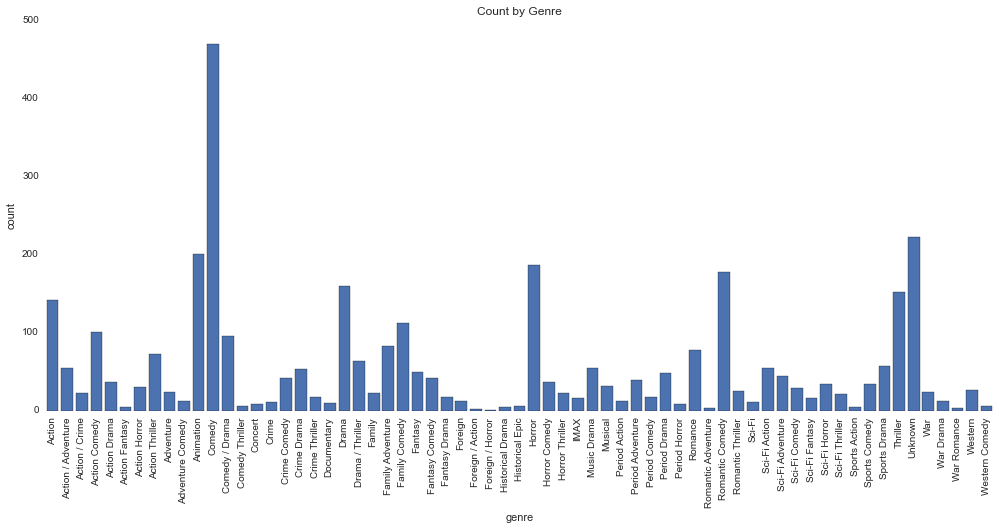

In [4]:
# ----------------------------------------
# Q: What's the most common genre overall?
# plot
# http://randyzwitch.com/creating-stacked-bar-chart-seaborn/
# ----------------------------------------
import seaborn as sb
%matplotlib inline

# ----- barplot
sb.set_context({"figure.figsize": (17, 7)})
p1 = sb.barplot(x='genre', y='count', data=matrix_common)
# p.set_xticklabels(rotation=90, horizontalalignment='right')
p1.set_xticklabels(labels=matrix_common['genre'], rotation=90)
p1.set_title('Count by Genre')

# # ----- factorplot
# p2 = sb.factorplot(x='genre', y='count', size=6.5, aspect=2.2, 
#                   data=matrix_common.sort(['count'], ascending=False))
# # Set the title of the plot
# ax = p2.axes.flat[0]
# ax.set_title('Count by Genre')

# # Rename the Y-Axis labels
# p2.set_ylabels('Count')

# # Fix the X-Axis tick markers
# p2.set_xticklabels(rotation=75, horizontalalignment='right')

In [5]:
# ----------------------------------------
# Q: What are top N genres by year?
# year | genre | count
# ----------------------------------------
matrix_common = matrix.groupby(['year','genre'])[['genre']].count()
matrix_common.rename(columns = {'genre': 'count'}, inplace=True)
matrix_common = matrix_common.reset_index()
matrix_common = matrix_common[matrix_common['genre'] != 'Unknown'] # remove unknown genre
display = matrix_common.sort(['year','count'], ascending=[False, False])
display.groupby(['year']).head(3)

,year,genre,count
1182,2014,Drama,16
1179,2014,Comedy,12
1178,2014,Animation,10
1149,2013,Comedy,18
1153,2013,Drama,11
1148,2013,Animation,10
1120,2012,Comedy,18
1119,2012,Animation,13
1112,2012,Action,7
1088,2011,Comedy,20


In [6]:
# ----------------------------------------
# Q: What are top N genres by year and month?
# year | month | genre | count
# ----------------------------------------
matrix_common = matrix.groupby(['year','month','genre'])[['genre']].count()
matrix_common.rename(columns = {'genre': 'count'}, inplace=True)
matrix_common = matrix_common.reset_index()
matrix_common = matrix_common[matrix_common['genre'] != 'Unknown'] # remove unknown genre

display_yrmo = matrix_common.sort(['year','month','count'], ascending=[True, True, False])
display_yrmo.groupby(['year','month']).head(3)

display_yr = matrix_common.sort(['year','count'], ascending=[True, False])
display_yr.groupby(['year']).head(5)

,year,month,genre,count
24,1980,6,Comedy,4
2,1980,2,Comedy,3
31,1980,7,Comedy,3
62,1980,12,Comedy,3
16,1980,5,Comedy,2
90,1981,5,Comedy,3
96,1981,6,Comedy,3
75,1981,2,Foreign,2
88,1981,4,Horror,2
98,1981,6,Fantasy,2


In [7]:
# ----------------------------------------
# Q: Top 5 genres by year/quarter?
# year | month | genre | count
# ----------------------------------------
matrix_common = matrix.groupby(['year','quarter','genre'])[['genre']].count()
matrix_common.rename(columns = {'genre': 'count'}, inplace=True)
matrix_common = matrix_common.reset_index()
matrix_common = matrix_common[matrix_common['genre'] != 'Unknown'] # remove unknown genre
display = matrix_common.sort(['year','quarter','count'], ascending=[True, True, False])
display.groupby(['year','quarter']).head(3)

,year,quarter,genre,count
2,1980,1,Comedy,4
0,1980,1,Action Thriller,1
1,1980,1,Animation,1
13,1980,2,Comedy,6
16,1980,2,Horror,2
19,1980,2,Romance,2
28,1980,3,Comedy,5
25,1980,3,Action,1
26,1980,3,Action Comedy,1
40,1980,4,Comedy,4


In [8]:
# ----------------------------------------
# Q: Top N genres by year/rank?
# year | rank | genre | count
# ----------------------------------------
matrix_common = matrix[matrix['rank']<=5].groupby(['year','genre'])[['genre']].count()
matrix_common.rename(columns = {'genre': 'count'}, inplace=True)

# matrix_common = matrix.groupby(['year','rank','genre'])[['genre']].count()
# matrix_common.rename(columns = {'genre': 'count'}, inplace=True)
matrix_common = matrix_common.reset_index()
matrix_common = matrix_common[matrix_common['genre'] != 'Unknown'] # remove unknown genre
display = matrix_common.sort(['year','genre','count'], ascending=[True, True, False])
display.groupby(['year','genre']).head(3)

# pd.unique(display['genre']) # list of unique genre

# outout list to a file
temp_df = display.groupby(['year','genre']).head(5)
temp_df.to_csv('tc_output_yeargenre.csv', sep='|', encoding='utf-8')

In [16]:
# ------------------------------------------
# Use Comedy, Action, Horror, Romantic, Drama 
# ------------------------------------------
import seaborn as sb
%matplotlib inline

matrix['isAction'] = matrix['genre'].map(lambda value: 1 if value.find('Action')>=0 else 0)
matrix['isAdventure'] = matrix['genre'].map(lambda value: 1 if value.find('Adventure')>=0 else 0)
matrix['isAnimation'] = matrix['genre'].map(lambda value: 1 if value.find('Animation')>=0 else 0)
matrix['isComedy'] = matrix['genre'].map(lambda value: 1 if value.find('Comedy')>=0 else 0)
matrix['isDrama'] = matrix['genre'].map(lambda value: 1 if value.find('Drama')>=0 else 0)
matrix['isFantasy'] = matrix['genre'].map(lambda value: 1 if value.find('Fantasy')>=0 else 0)
matrix['isHorror'] = matrix['genre'].map(lambda value: 1 if (value.find('Horror')>=0 or value.find('Thriller')>=0) else 0)
matrix['isRomance'] = matrix['genre'].map(lambda value: 1 if value.find('Romance')>=0 else 0)

matrix.head()

# --------------------------------
# output list to a file
# matrix.to_csv('tc_output_matrix.csv', sep='|')
# --------------------------------
# pd.Index(matrix['genre'],'comedy')
# matrix_comedy = matrix[matrix['genre'].find('Comedy')>=0]
# matrix_comedy
# --------------------------------
# Initialize a grid of plots with an Axes for each walk
# grid = sns.FacetGrid(df, col="walk", hue="walk", col_wrap=5, size=1.5)

,rank,title,link,year,genre,release,month,quarter,used_for_year,isAction,isAdventure,isAnimation,isComedy,isDrama,isFantasy,isHorror,isRomance
0,1,The Empire Strikes Back,http://www.boxofficemojo.com/movies/?id=starwa...,1980,Sci-Fi Fantasy,1980-05-21,5,2,1982,0,0,0,0,0,1,0,0
1,2,9 to 5,http://www.boxofficemojo.com/movies/?id=9to5.htm,1980,Comedy,1980-12-19,12,4,1982,0,0,0,1,0,0,0,0
2,3,Stir Crazy,http://www.boxofficemojo.com/movies/?id=stircr...,1980,Comedy,1980-12-12,12,4,1982,0,0,0,1,0,0,0,0
3,4,Airplane!,http://www.boxofficemojo.com/movies/?id=airpla...,1980,Comedy,1980-06-27,6,2,1982,0,0,0,1,0,0,0,0
4,5,Any Which Way You Can,http://www.boxofficemojo.com/movies/?id=anywhi...,1980,Action Comedy,1980-12-17,12,4,1982,1,0,0,1,0,0,0,0


In [9]:
# --------------------------------------------
# S&P 500 - data before
# --------------------------------------------
import pandas as pd
sp500 = pd.read_csv('2015-07-07 sp500.csv', sep=',')
sp500['Date'] = pd.to_datetime(sp500['Date']) # convert to date type
sp500 = sp500[ (sp500['Date']>='1980-01-01') & (sp500['Date']<='2014-12-31')] # subset from 1980 to 2014-12-31
sp500['year'] = sp500['Date'].map(lambda value: value.year)
sp500['month'] = sp500['Date'].map(lambda value: value.month)
sp500.head()

,Date,Open,High,Low,Close,Volume,Adj Close,year,month
6,2014-12-01,2065.780029,2093.550049,1972.560059,2058.899902,3788631300,2058.899902,2014,12
7,2014-11-03,2018.209961,2075.760010,2001.010010,2067.560059,3479201500,2067.560059,2014,11
8,2014-10-01,1971.439941,2018.189941,1820.660034,2018.050049,4260310800,2018.050049,2014,10
9,2014-09-02,2004.069946,2019.260010,1964.040039,1972.290039,3364623800,1972.290039,2014,9
10,2014-08-01,1929.800049,2005.040039,1904.780029,2003.369995,2875718500,2003.369995,2014,8


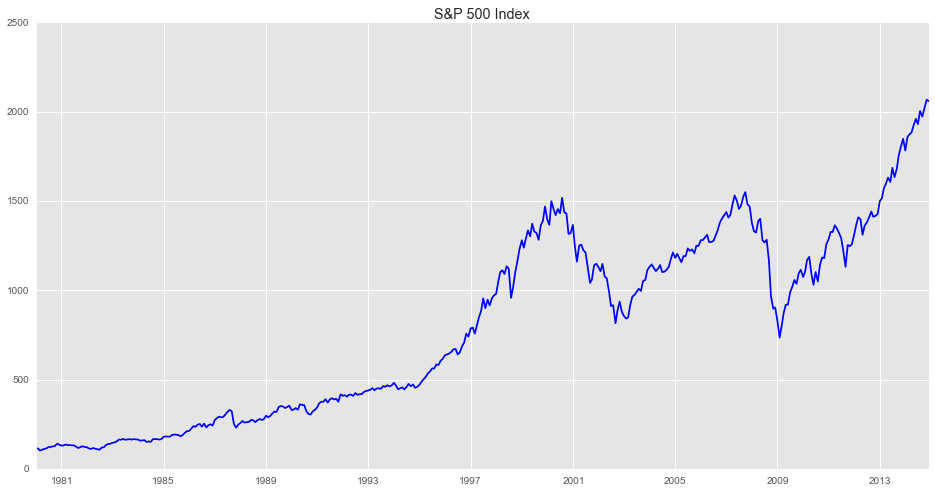

In [10]:
# --------------------------------------------
# S&P 500
# --------------------------------------------
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(16, 8))
plt.title('S&P 500 Index')
x = sp500['Date'] 
y = sp500['Close']
plt.plot(x, y, color='b')

In [12]:
# --------------------------------------------
# S&P 500 - data after
# --------------------------------------------
# sp500[(sp500['month']==1) | (sp500['month']==12) ] # test
sp500_01 = sp500[(sp500['month']==1)]
sp500_12 = sp500[(sp500['month']==12)]
temp = pd.merge(sp500_01, sp500_12, on=['year'])

sp500_year = temp[['year','Open_x', 'Adj Close_y', 'Volume_x']]
sp500_year.rename(columns = {'Open_x':'open_price', 'Adj Close_y':'close_price', 'Volume_x':'volume'}, inplace=True)
sp500_year['pnl'] = sp500_year.close_price - sp500_year.open_price
# sp500_year['advance'] = sp500_year.apply(lambda value: value['close']-value['open'], axis=1)
sp500_year['advance'] = sp500_year['pnl'].map(lambda value: 1 if value>0 else 0)

sp500_year.head()

/Users/tommiechen/anaconda3/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:2417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Users/tommiechen/anaconda3/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tommiechen/anaconda3/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata

,year,open_price,close_price,volume,pnl,advance
0,2014,1845.859985,2058.899902,3806266600,213.039917,1
1,2013,1426.189941,1848.359985,3802304200,422.170044,1
2,2012,1258.859985,1426.189941,4190155500,167.329956,1
3,2011,1257.619995,1257.599976,4816605000,-0.020019,0
4,2010,1116.560059,1257.640015,5071601500,141.079956,1


In [24]:
# sp500_year.head(10).head()

matrix['used_for_year'] = matrix['year']+2 # use T year to predict T+1 year's stock performance

data_orig = pd.merge(matrix, sp500_year, left_on = 'used_for_year', right_on = 'year', suffixes={'_sp','_'})
data = data_orig[data_orig['year_sp'] <= 2012]
data.head()

# data_orig = matrix.merge(sp500_year, on='year')
# data = data_orig[data_orig['year'] <= 2009]
# data[matrix_merge_year['year']<=2005].head()
# data.head()

,rank,title,link,year_sp,genre,release,month,quarter,used_for_year,isAction,...,isDrama,isFantasy,isHorror,isRomance,year_,open_price,close_price,volume,pnl,advance
0,1,The Empire Strikes Back,http://www.boxofficemojo.com/movies/?id=starwa...,1980,Sci-Fi Fantasy,1980-05-21,5,2,1982,0,...,0,1,0,0,1982,122.550003,140.639999,52087000,18.089996,1
1,2,9 to 5,http://www.boxofficemojo.com/movies/?id=9to5.htm,1980,Comedy,1980-12-19,12,4,1982,0,...,0,0,0,0,1982,122.550003,140.639999,52087000,18.089996,1
2,3,Stir Crazy,http://www.boxofficemojo.com/movies/?id=stircr...,1980,Comedy,1980-12-12,12,4,1982,0,...,0,0,0,0,1982,122.550003,140.639999,52087000,18.089996,1
3,4,Airplane!,http://www.boxofficemojo.com/movies/?id=airpla...,1980,Comedy,1980-06-27,6,2,1982,0,...,0,0,0,0,1982,122.550003,140.639999,52087000,18.089996,1
4,5,Any Which Way You Can,http://www.boxofficemojo.com/movies/?id=anywhi...,1980,Action Comedy,1980-12-17,12,4,1982,1,...,0,0,0,0,1982,122.550003,140.639999,52087000,18.089996,1


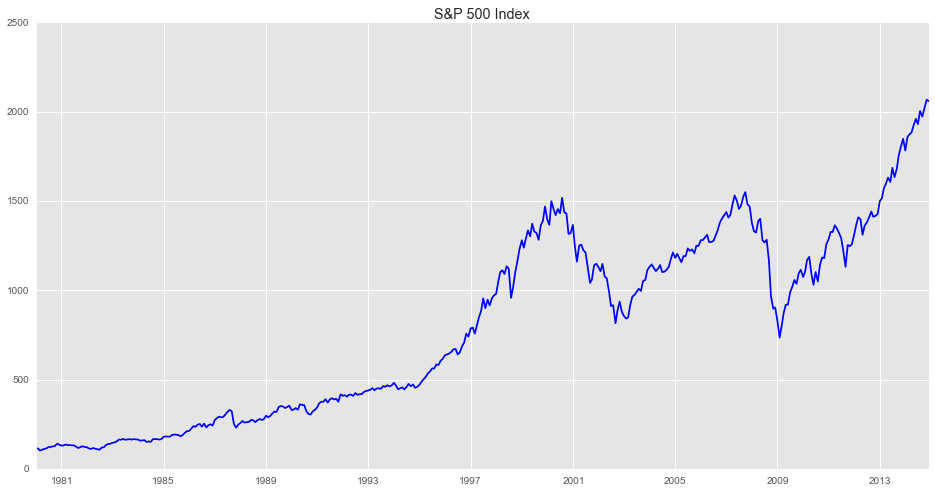

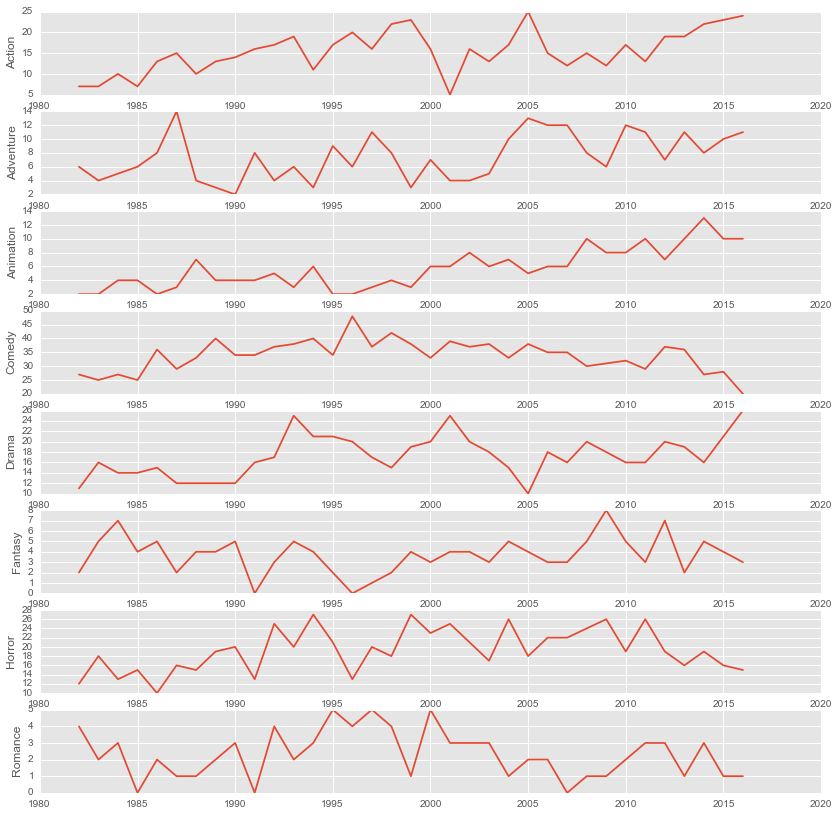

In [23]:
# -------------------------------------
# plot the count by year and genre & SP500
# -------------------------------------
# ------------------------------------ SP500
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.title('S&P 500 Index')
plt.plot(sp500['Date'], sp500['Close'], color='b')

# ------------------------------------ genre
matrix_iplot = matrix[['used_for_year','isAction','isAdventure','isAnimation','isComedy','isDrama','isFantasy','isHorror','isRomance']].groupby('used_for_year').sum().reset_index()
# matrix_iplot.head()
plt.style.use('ggplot')
plt.figure(figsize=(14, 14))
# plt.title('isAction')
x = matrix_iplot['used_for_year'] 
y1 = matrix_iplot['isAction']
y2 = matrix_iplot['isAdventure']
y3 = matrix_iplot['isAnimation']
y4 = matrix_iplot['isComedy']
y5 = matrix_iplot['isDrama']
y6 = matrix_iplot['isFantasy']
y7 = matrix_iplot['isHorror']
y8 = matrix_iplot['isRomance']
# plt.plot(x, y1, x, y2)
# -------------------------------------

plt.title('Genre Count by Year')
plt.subplot(8, 1, 1)
plt.plot(x, y1)
plt.ylabel('Action')
plt.grid(True)

plt.subplot(8, 1, 2)
plt.plot(x, y2)
plt.ylabel('Adventure')
plt.grid(True)

plt.subplot(8, 1, 3)
plt.plot(x, y3)
plt.ylabel('Animation')
plt.grid(True)

plt.subplot(8, 1, 4)
plt.plot(x, y4)
plt.ylabel('Comedy')
plt.grid(True)

plt.subplot(8, 1, 5)
plt.plot(x, y5)
plt.ylabel('Drama')
plt.grid(True)

plt.subplot(8, 1, 6)
plt.plot(x, y6)
plt.ylabel('Fantasy')
plt.grid(True)

plt.subplot(8, 1, 7)
plt.plot(x, y7)
plt.ylabel('Horror')
plt.grid(True)

plt.subplot(8, 1, 8)
plt.plot(x, y8)
plt.ylabel('Romance')
plt.grid(True)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

model = LogisticRegression(penalty = 'l2', C = 1)
X = data[['isAction','isAdventure','isAnimation','isComedy','isDrama','isFantasy','isHorror','isRomance']]
y = data['advance']

scores = cross_val_score(model, X, y, cv=3)   #AR note: change number of cross validation from 'cv'
print(scores)

[ 0.78746594  0.78818182  0.78798908]


In [102]:
def get_coefficients(df, model):
    cdf = pd.DataFrame({'Features': df.columns, 'Coef': model.coef_[0]})
    return cdf.sort('Coef', ascending=False)

model.fit(X, y)
print(scores)
get_coefficients(X, model)

[ 0.78746594  0.78818182  0.78798908]


,Coef,Features
0,0.064615,isAction
1,0.021570,isAdventure
5,-0.252339,isFantasy
3,-0.256690,isComedy
4,-0.357327,isDrama
6,-0.509928,isHorror
7,-0.567453,isRomance
2,-0.646834,isAnimation


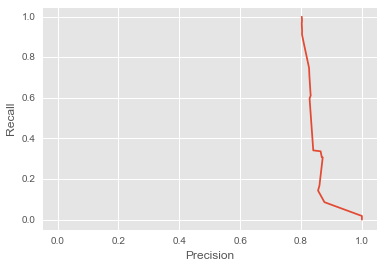

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.cross_validation import train_test_split

#AR note: add "astype(float)" to revolve the problem of 'float' object has no attribute 'exp'
X = data[['isAction','isAdventure','isAnimation','isComedy','isDrama','isFantasy','isHorror','isRomance']].fillna(0).astype(float) 
y = data['advance']

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Learn the model parameters on the training set
model.fit(X_train, y_train)

# Compute the predicted probabilities on the test set 
probas_ = model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve (y_test, probas_[:, 1])

plt.plot(precision, recall)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')

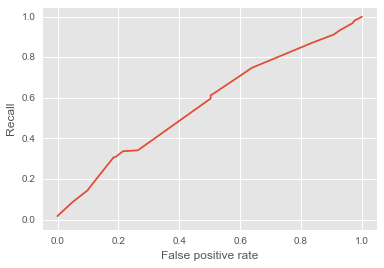

In [27]:
false_positive_rate, recall, thresholds = roc_curve (y_test, probas_[:, 1])

plt.plot(false_positive_rate, recall)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('Recall')

In [28]:
#AR note: default cv = 3 if you don't specifiy it
print("Precision cross-validation", cross_val_score(model, X, y, scoring='precision', cv=3))
#print("Precision cross-validation", cross_val_score(model, X, y, scoring='precision', cv=3))

print("Recall cross-validation", cross_val_score(model, X, y, scoring='recall', cv=3))

print("AUC cross-validation", cross_val_score(model, X, y, scoring='roc_auc', cv=3))  #AR note: higher AUC the better (max=1)

Precision cross-validation [ 0.78746594  0.78818182  0.78798908]
Recall cross-validation [ 1.  1.  1.]
AUC cross-validation [ 0.53440245  0.55466039  0.54079979]


Precision cross-validation [ 0.78787879  0.78787879  0.78787879  0.78787879  0.78787879]
Recall cross-validation [ 1.  1.  1.  1.  1.]
AUC cross-validation [ 0.56861951  0.60908654  0.54373626  0.54252747  0.53837912]


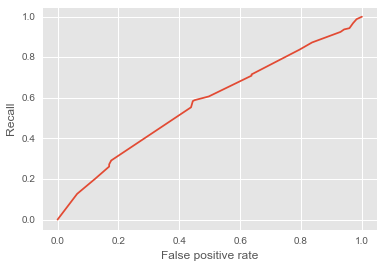

In [29]:
# --------------------------------------------------------------------------------
# Blockbuster lost significant revenue and filed for bankruptcy protection on September 23, 2010
# Test with different T vs. T+n Year
# 2014 AUC cross-validation [ 0.56861951  0.60908654  0.54373626  0.54252747  0.53837912]
# 2013 AUC cross-validation [ 0.57049286  0.61745714  0.55295714  0.54049286  0.54835   ]
# 2012 AUC cross-validation [ 0.56369792  0.63643601  0.54860119  0.53710565  0.55345238]
# 2011 AUC cross-validation [ 0.56189441  0.64641304  0.54313665  0.53781056  0.56033385]
# 2010 AUC cross-validation [ 0.55325181  0.64289855  0.51172101  0.56281703  0.54637681]
# 2009 AUC cross-validation [ 0.55513258  0.64279356  0.52390152  0.56287879  0.54810606]
# 2008 AUC cross-validation [ 0.56511905  0.64032738  0.54130952  0.57436508  0.54862103]
# 2007 AUC cross-validation [ 0.55917857  0.65755952  0.5484881   0.58103571  0.55492857]
# 2006 AUC cross-validation [ 0.556      0.65775    0.5408625  0.5669125  0.555875 ]
# 2005 AUC cross-validation [ 0.54363158  0.67011842  0.54768421  0.57847368  0.55531579]
# --------------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

model = LogisticRegression(penalty = 'l2', C = 1)
X = data[['isAction','isAdventure','isAnimation','isComedy','isDrama','isFantasy','isHorror','isRomance']]
y = data['advance']

scores = cross_val_score(model, X, y, cv=3)   #AR note: change number of cross validation from 'cv'
# print(scores)
# ---------------------------------------------------------------------------------

def get_coefficients(df, model):
    cdf = pd.DataFrame({'Features': df.columns, 'Coef': model.coef_[0]})
    return cdf.sort('Coef', ascending=False)

model.fit(X, y)
# get_coefficients(X, model) # output coefficients
# ---------------------------------------------------------------------------------

matrix['used_for_year'] = matrix['year']+2 # use T year to predict T+1 year's stock performance
data_orig = pd.merge(matrix, sp500_year, left_on = 'used_for_year', right_on = 'year', suffixes={'_sp','_movie'})
data = data_orig[data_orig['year_sp'] <= 2014]

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.cross_validation import train_test_split

#AR note: add "astype(float)" to revolve the problem of 'float' object has no attribute 'exp'
X = data[['isAction','isAdventure','isAnimation','isComedy','isDrama','isFantasy','isHorror','isRomance']].fillna(0).astype(float) 
y = data['advance']

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Learn the model parameters on the training set
model.fit(X_train, y_train)

# Compute the predicted probabilities on the test set 
probas_ = model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve (y_test, probas_[:, 1])

# plt.plot(precision, recall)
# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('Precision')
# plt.ylabel('Recall')
# --------------------------------------------------------------------------------

false_positive_rate, recall, thresholds = roc_curve (y_test, probas_[:, 1])

plt.plot(false_positive_rate, recall)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('Recall')
# --------------------------------------------------------------------------------
#AR note: default cv = 3 if you don't specifiy it
print("Precision cross-validation", cross_val_score(model, X, y, scoring='precision', cv=5))
print("Recall cross-validation", cross_val_score(model, X, y, scoring='recall', cv=5))
print("AUC cross-validation", cross_val_score(model, X, y, scoring='roc_auc', cv=5))  #AR note: higher AUC the better (max=1)


AUC cross-validation [ 0.53027511  0.54459764  0.54464324]
Area under the ROC curve : 0.576075


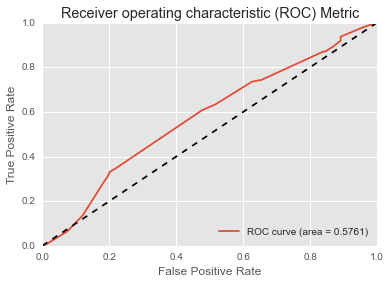

In [30]:
# ---------------------------------------------------------------------------------
# 
# 
# 
# ---------------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

model = LogisticRegression(penalty = 'l2', C = 0.8)
X = data[['isAction','isAdventure','isAnimation','isComedy','isDrama','isFantasy','isHorror','isRomance']]
y = data['advance']

scores = cross_val_score(model, X, y, cv=3)   #AR note: change number of cross validation from 'cv'
# print(scores)
# ---------------------------------------------------------------------------------

def get_coefficients(df, model):
    cdf = pd.DataFrame({'Features': df.columns, 'Coef': model.coef_[0]})
    return cdf.sort('Coef', ascending=False)

model.fit(X, y)
# get_coefficients(X, model) # output coefficients
# ---------------------------------------------------------------------------------

matrix['used_for_year'] = matrix['year']+2 # use T year to predict T+1 year's stock performance
data_orig = pd.merge(matrix, sp500_year, left_on = 'used_for_year', right_on = 'year', suffixes={'_sp','_movie'})
data = data_orig[data_orig['year_sp'] <= 2012]

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.cross_validation import train_test_split

#AR note: add "astype(float)" to revolve the problem of 'float' object has no attribute 'exp'
X = data[['isAction','isAdventure','isAnimation','isComedy','isDrama','isFantasy','isHorror','isRomance']].fillna(0).astype(float) 
y = data['advance']

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Learn the model parameters on the training set
model.fit(X_train, y_train)

# Compute the predicted probabilities on the test set 
probas_ = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])

#AR note: default cv = 3 if you don't specifiy it
# print("Precision cross-validation", cross_val_score(model, X, y, scoring='precision', cv=5))
# print("Recall cross-validation", cross_val_score(model, X, y, scoring='recall', cv=5))
print("AUC cross-validation", cross_val_score(model, X, y, scoring='roc_auc', cv=3))  #AR note: higher AUC the better (max=1)

# -------------------------------------------------------------------------
# Compute Area Under the Curve (AUC) using the trapezoidal rule
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plot ROC curve
import pylab as pl
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic (ROC) Metric')
pl.legend(loc="lower right")
pl.show()

In [379]:
# from sklearn import metrics
# import pandas as pd

# # preds = clf.predict_proba(Xtest)[:,1]
# preds = model.predict_proba(X_test)[:,1]

# # fpr, tpr, _ = metrics.roc_curve(ytest, preds)
# fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
# plt.plot(fpr, tpr, )